## Preparation

##### Import Functions

In [1]:
from Scripts.LoadImage import LoadImage as LoadImage
from Scripts.Fuzzify import Fuzzify as Fuzzify
from Class.Helper import Helper as Helper
from Scripts.Ki67 import Ki67 as Ki67

In [2]:
import numpy as np
import pandas as pd
from os import listdir
from skimage import io
from skimage.draw import circle, circle_perimeter
from matplotlib import pyplot as plt
from skimage.color import rgb2hsv, rgb2hed, hed2rgb, rgb2gray

##### Functions

In [4]:
def getRecall(markers, mask):
    radius = 3
    hits = markers.apply(lambda marker: mask[int(marker['y'])-radius:int(marker['y']) + radius + 1, int(marker['x'])-radius:int(marker['x']) + radius + 1].any(),axis=1)
    recall = hits.sum() / len(hits)
    return recall

def validateResults(folder_name, low_x, high_x, low_y, high_y, show_images = False):
    path = settings.data_folder_veryfication
    mask = pickle.load(open(settings.backup_folder + "Images/" + "Test_" + folder_name + "_" + settings.class_1 + "_df_results"  + ".p", "rb"))
    mask = mask.sort_index()
    
    if settings.class_1 == "brown":
        searched_class = 1
    else:
        searched_class = 2
    
    mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, high_x - low_x))
    
    mask = [np.ones(3) if j == settings.class_1 else np.zeros(3) for row in mask for j in row]
    mask = np.array(mask)
    mask = mask.reshape((-1, high_x - low_x, 3))

    from skimage.morphology import binary_closing
    from skimage.morphology import disk, remove_small_objects
    from skimage.color import rgb2gray
    from skimage import data, io, segmentation, color

    file_path = path + folder_name
    image_raw= io.imread(file_path + "/fragment.png")
    base = io.imread(file_path + "/base.png")
    markers = pd.read_csv(file_path + "/markers.csv")

#     k = 1000 / base.shape[1]
    k = 3
    markers.loc[:, 'x'] = markers.x.apply(lambda x: np.ceil(x / k))
    markers.loc[:, 'y'] = markers.y.apply(lambda y: np.ceil(y / k))
    markers = markers.drop(markers[((markers.x < low_x) | (markers.x > high_x)) | ((markers.y < low_y) | (markers.y > high_y))].index)
    markers.loc[:, 'x'] = markers.x.apply(lambda x: x - low_x)
    markers.loc[:, 'y'] = markers.y.apply(lambda y: y - low_y)

    markers = markers.loc[markers.type == searched_class]

    if show_images:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(70, 45))
    mask_gray = rgb2gray(mask)
    if show_images:
        ax[0].imshow(mask, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(1))
    if show_images:
        ax[1].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = remove_small_objects(mask_gray, 3)
    if show_images:
        ax[2].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(2))
    if show_images:
        ax[3].imshow(mask_gray, cmap=plt.cm.gray)

    mask_gray = mask_gray.astype(bool)
    recall = getRecall(markers, mask_gray)
    
    if show_images:
        for center_y, center_x in zip(markers.y, markers.x):
            circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
            image_raw[circy, circx] = (220, 20, 20)
        
        ax[4].imshow(image_raw, cmap=plt.cm.gray)
        plt.show()
        
    return recall

##### Import Settings

In [363]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings
settings = Settings(generalSettings)

##### Load Image

In [364]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png


### Train mode

In [262]:
fuzzify = Fuzzify()
changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

In [ ]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings


for cell_type in ["brown"]:
    generalSettings.gausses = 5
    generalSettings.style = "Gaussian Equal"
    generalSettings.adjustment_value = -1
    generalSettings.class_1 = cell_type
    generalSettings.features_type = 11
    settings = Settings(generalSettings)        

    # Generate Rules
    loadImage = LoadImage()
    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

    fuzzify = Fuzzify()
    changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

    # Validate Results
    for file_name in ["1628-05", "18583-04", "31374-10",]:
        generalSettings.file_name = file_name
        settings = Settings(generalSettings)     
        loadImage = LoadImage()
        samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = -1)

        ki67Test = Ki67(settings, settings.s_function_width, False)
        ki67Test.noOptymalizationWorker(settings)

        if file_name == "1628-05":
            recall_1 = validateResults(settings.file_name, 85, 449, 172, 533, False)
        elif file_name == "18583-04":
            recall_2 = validateResults(settings.file_name, 1732, 2011, 583, 995, False)
        else:
            recall_3 = validateResults(settings.file_name, 432, 794, 300, 566, False)
    avg_recall = (recall_1 + recall_2 + recall_3) / 3
    helper = Helper()

    fuzzification_data = ["Ki67", settings.style, settings.gausses, settings.adjustment, settings.class_1, settings.features_type, samples_stats, train_stats, test_stats, changed_decisions, round(changed_decisions / train_samples, 2), implicants_number, settings.feature_numbers, features_number_after_reduct, recall_1, recall_2, recall_3, avg_recall, execution_time]
    helper.saveFuzzificationStatsKi67(fuzzification_data)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png



  3%|██▍                                                                        | 4279/131404 [00:09<04:27, 475.15it/s]


  6%|████▌                                                                      | 7940/131404 [00:18<05:35, 368.15it/s]


  9%|██████▋                                                                   | 11890/131404 [00:28<06:22, 312.82it/s]


 12%|████████▉                                                                 | 15964/131404 [00:39<05:03, 380.89it/s]


 15%|███████████▎                                                              | 20024/131404 [00:50<06:12, 299.19it/s]


 18%|█████████████▋                                                            | 24237/131404 [01:00<04:29, 397.51it/s]


 21%|███████████████▊                                                          | 28143/131404 [01:11<04:39, 369.90it/s]


 24%|█████████████████▉                                                        | 31933/131404 [01:21<05:53, 281.25it/s]


 27%|███████████████████▉                                                      | 35376/131404 [01:32<05:27, 292.95it/s]


 29%|█████████████████████▋                                                    | 38508/131404 [01:43<05:32, 279.03it/s]


 32%|███████████████████████▌                                                  | 41796/131404 [01:53<05:32, 269.54it/s]


 35%|█████████████████████████▌                                                | 45493/131404 [02:05<05:59, 239.11it/s]


 37%|███████████████████████████▌                                              | 49008/131404 [02:15<03:36, 381.32it/s]


 40%|█████████████████████████████▌                                            | 52564/131404 [02:26<04:17, 306.49it/s]


 43%|███████████████████████████████▋                                          | 56307/131404 [02:37<03:13, 388.33it/s]


 46%|█████████████████████████████████▉                                        | 60336/131404 [02:48<02:51, 414.96it/s]


 49%|████████████████████████████████████                                      | 63966/131404 [02:59<03:34, 314.84it/s]


 51%|█████████████████████████████████████▉                                    | 67433/131404 [03:10<03:38, 292.78it/s]


 55%|████████████████████████████████████████▎                                 | 71627/131404 [03:21<02:16, 436.93it/s]


 57%|██████████████████████████████████████████▌                               | 75544/131404 [03:33<04:01, 231.08it/s]


 60%|████████████████████████████████████████████▌                             | 79024/131404 [03:44<02:58, 293.88it/s]


 62%|██████████████████████████████████████████████                            | 81736/131404 [03:55<03:19, 248.41it/s]


 64%|███████████████████████████████████████████████▌                          | 84353/131404 [04:05<03:39, 214.79it/s]


 66%|████████████████████████████████████████████████▉                         | 86812/131404 [04:15<02:53, 256.81it/s]


 68%|██████████████████████████████████████████████████▎                       | 89232/131404 [04:24<02:19, 302.14it/s]


 70%|███████████████████████████████████████████████████▍                      | 91417/131404 [04:32<02:12, 302.55it/s]


 71%|████████████████████████████████████████████████████▊                     | 93783/131404 [04:42<03:01, 206.89it/s]


 73%|██████████████████████████████████████████████████████                    | 96007/131404 [04:51<03:09, 187.19it/s]


 75%|███████████████████████████████████████████████████████▍                  | 98461/131404 [05:00<01:58, 276.92it/s]


 77%|████████████████████████████████████████████████████████                 | 100887/131404 [05:09<01:54, 267.24it/s]


 79%|█████████████████████████████████████████████████████████▍               | 103396/131404 [05:19<01:42, 274.59it/s]


 81%|██████████████████████████████████████████████████████████▉              | 105997/131404 [05:28<01:26, 294.17it/s]


 83%|████████████████████████████████████████████████████████████▎            | 108531/131404 [05:37<01:22, 278.48it/s]


 84%|█████████████████████████████████████████████████████████████▌           | 110780/131404 [05:47<01:42, 202.17it/s]


 86%|██████████████████████████████████████████████████████████████▋          | 112899/131404 [05:56<01:11, 257.67it/s]


 88%|████████████████████████████████████████████████████████████████         | 115239/131404 [06:06<01:07, 238.65it/s]


 90%|█████████████████████████████████████████████████████████████████▍       | 117703/131404 [06:16<01:09, 198.45it/s]


 92%|██████████████████████████████████████████████████████████████████▉      | 120484/131404 [06:27<00:40, 272.32it/s]


 95%|█████████████████████████████████████████████████████████████████████    | 124205/131404 [06:37<00:19, 371.12it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 128816/131404 [06:47<00:05, 497.95it/s]


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [06:57<00:00, 314.87it/s]

-----------------------------------------------------------------------------------
Time: 435.27352571487427
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png


### Test mode

In [264]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = True)

../Data/Ki67-Test/blue.png


In [460]:
ki67Test = Ki67(settings, settings.s_function_width, False)

In [461]:
ki67Test.noOptymalizationWorker(settings)

100%|███████████████████████████████████████████████████████████████████████████| 11020/11020 [00:30<00:00, 360.18it/s]


-----------------------------------------------------------------------------------
Time: 31.962507963180542
-----------------------------------------------------------------------------------


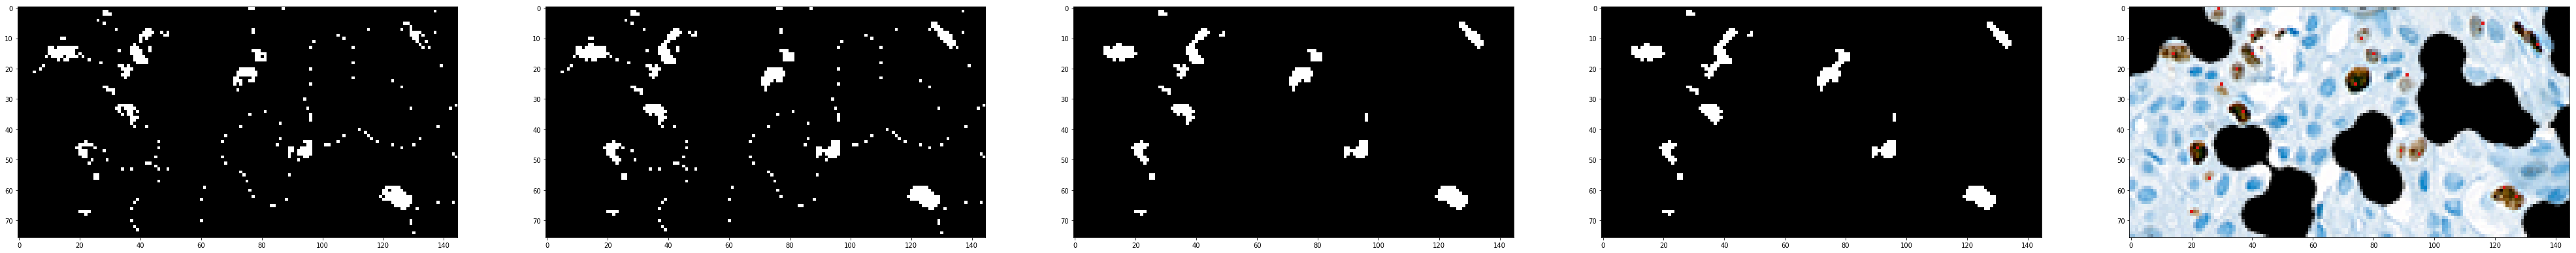

0.8

In [538]:
validateResults(settings.file_name, 405, 550, 68, 144, True)